In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense , Dropout

In [7]:
data = pd.read_csv('creditcard.csv',parse_dates = ['Time'])

In [4]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  object 
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

<Axes: xlabel='Class', ylabel='count'>

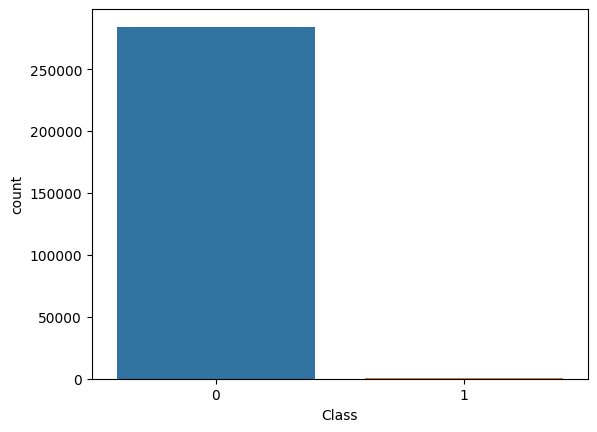

In [9]:
sns.countplot(x = 'Class',data =data)

In [17]:
frauds = data[data.Class == 1]
normal = data[data.Class == 0]

In [18]:
frauds.shape

(492, 31)

In [19]:
normal.shape

(284315, 31)

In [20]:
frauds.describe()['Amount']

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [22]:
normal.describe()['Amount']

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

Text(0.5, 0, 'NORMAL')

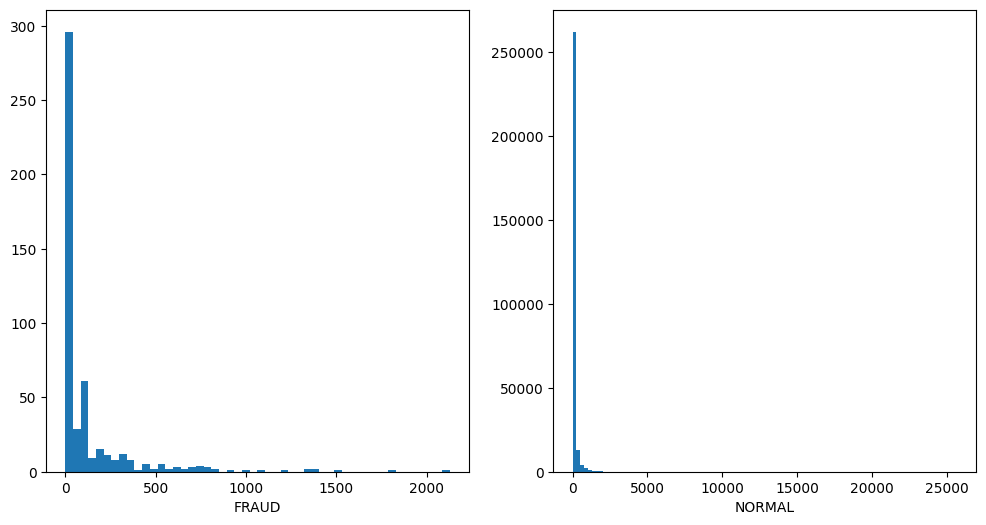

In [30]:
fig , axes = plt.subplots(nrows =1 ,ncols=2,figsize=(12,6))
axes[0].hist(frauds['Amount'],bins=50)
axes[1].hist(normal['Amount'],bins=100)
plt.tight_layout
axes[0].set_xlabel('FRAUD')
axes[1].set_xlabel('NORMAL')

In [51]:
from sklearn.preprocessing import StandardScaler

df = data.drop(['Time'], axis=1)

df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1,1))

Training our model on normal transactions

In [52]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(df, test_size=0.2, random_state=42)
X_train = X_train[X_train['Class'] == 0]
X_train = X_train.drop(['Class'], axis=1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

In [54]:
X_train.shape[1]

29

In [55]:
from keras.layers import Input
from keras import regularizers
from keras.models import Model
input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim, ))
layer1 = Dense(units = 14 , activation = 'tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
layer2 = Dense(units = 7 , activation = 'relu')(layer1)
layer3 = Dense(units = 7 , activation = 'tanh')(layer2)
output = Dense(units = input_dim,activation = 'relu')(layer3)
model = Model(inputs=input_layer, outputs=output)

In [56]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [57]:
from keras.callbacks import ModelCheckpoint, TensorBoard
nb_epoch = 100
batch_size = 32
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = model.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/100
7108/7108 [==============================] - 22s 3ms/step - loss: 0.8061 - accuracy: 0.5696 - val_loss: 0.7773 - val_accuracy: 0.6663
Epoch 2/100
7108/7108 [==============================] - 21s 3ms/step - loss: 0.7343 - accuracy: 0.6802 - val_loss: 0.7563 - val_accuracy: 0.6900
Epoch 3/100
7108/7108 [==============================] - 19s 3ms/step - loss: 0.7199 - accuracy: 0.7049 - val_loss: 0.7489 - val_accuracy: 0.7074
Epoch 4/100
7108/7108 [==============================] - 21s 3ms/step - loss: 0.7141 - accuracy: 0.7161 - val_loss: 0.7439 - val_accuracy: 0.7165
Epoch 5/100
7108/7108 [==============================] - 20s 3ms/step - loss: 0.7105 - accuracy: 0.7192 - val_loss: 0.7417 - val_accuracy: 0.7171
Epoch 6/100
7108/7108 [==============================] - 20s 3ms/step - loss: 0.7087 - accuracy: 0.7186 - val_loss: 0.7405 - val_accuracy: 0.7207
Epoch 7/100
7108/7108 [==============================] - 22s 3ms/step - loss: 0.7072 - accuracy: 0.7201 - val_loss: 0.7395 -

In [62]:
from keras.models import load_model
autoencoder = load_model('model.h5')

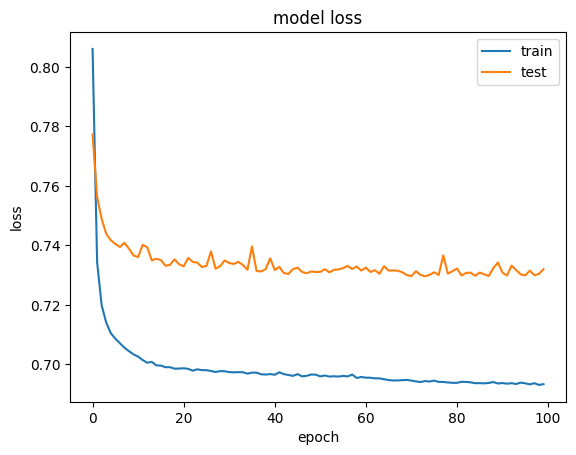

In [63]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [64]:
predictions = autoencoder.predict(X_test)

1781/1781 [==============================] - 6s 3ms/step


In [65]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [66]:
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.728756,0.001720
std,3.466302,0.041443
min,0.050213,0.000000
25%,0.239230,0.000000
50%,0.382341,0.000000
75%,0.607975,0.000000
max,268.895606,1.000000


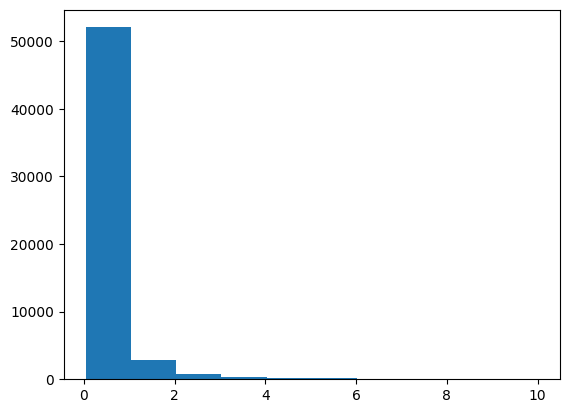

In [67]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

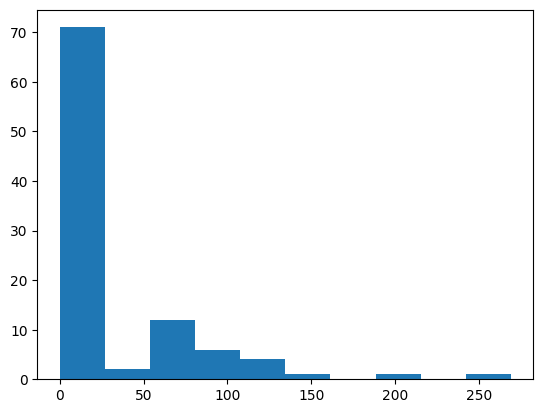

In [68]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [69]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

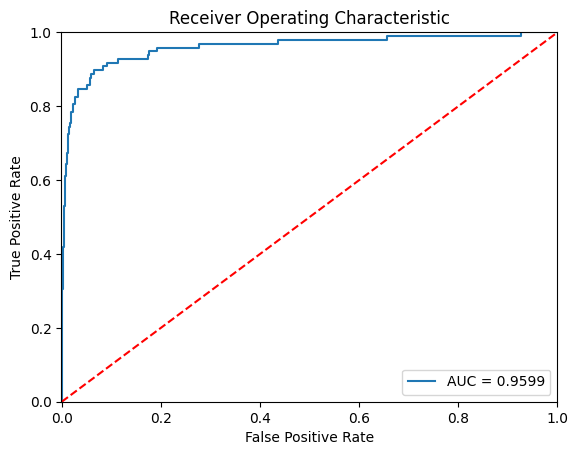

In [70]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

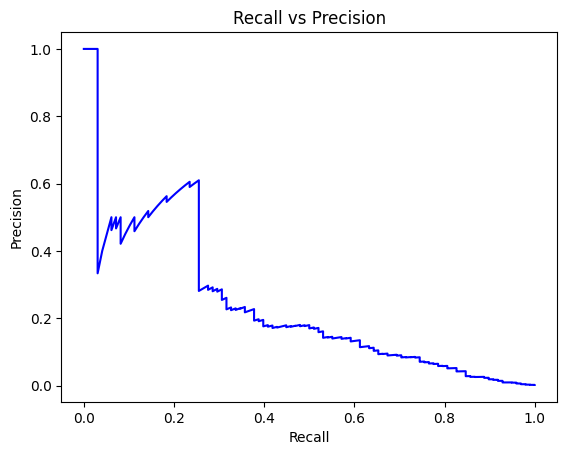

In [71]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

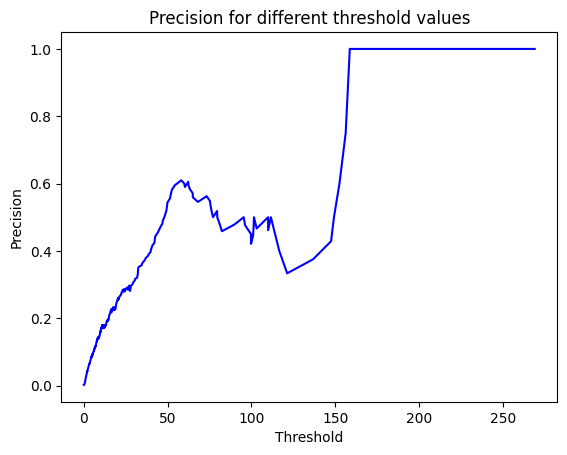

In [72]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

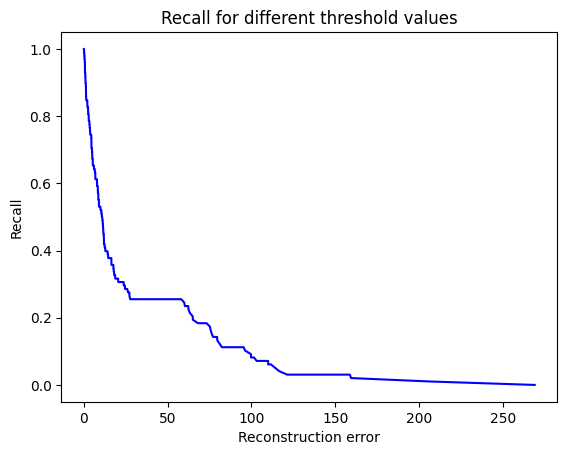

In [73]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

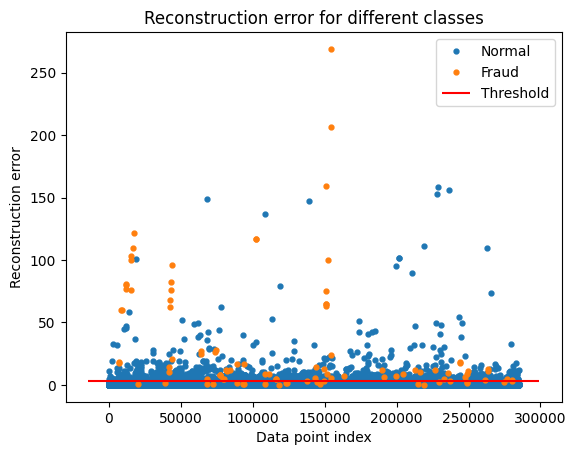

In [74]:
threshold = 2.9
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [81]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df['true_class'], y_pred)
print(conf_matrix)

[[55567  1297]
 [   19    79]]
